## USGS Data Acquisition
#### Aditi Shrivastava

In this notebook, we comprehensively analyze how wildfire smoke, an increasingly pervasive environmental factor, influences the efficiency and output of the agricultural sector in the city of Rapid City, South Dakota. Specifically, we forecast the Agricultural TFP in Rapid City to the year 2050 based on a number of wildfire smoke related factors, and find that the agriculture sector will fail to meet productivity expectations in the year 2050 if wildfire smoke continues to increase at the same pace.

This analysis is heavily inspired by the work done in the paper [Air pollution as a substantial threat to the improvement of agricultural total factor productivity: Global evidence](https://www.sciencedirect.com/science/article/pii/S0160412023001150?via%3Dihub) by researchers Daxin Dong and Jiaxin Wang at the Institute of Western China Economic Research, Southwestern University of Finance and Economics in China. While the data and models in this notebook bear no semblace to the results produced by Dong and Wang, the focus and motive behind this exploration was largely inspired by the aforementioned.

## 1. 
Perform all necessary imports and load in data. All data is contained in ```../data/```.

In [1]:
# imports 

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
# All data is contained in ../data/

# Data on wildfires taking place within 1250 miles of Rapid City after the year 1963
# Extracted in ./1.USGS_data_acquisition.ipynb
wildfire = pd.read_csv('../data/final_USGS_data.csv')

# Data on the yearly PM2.5 and O3 levels in Rapid City
# Extracted in 2.EPA_data_acquisition.ipynb
epa = pd.read_csv('../data/final_EPA_data.csv')

# Data on the yearly historical AgTFP levels
# Taken directly from USDA website
# https://www.ers.usda.gov/data-products/agricultural-productivity-in-the-u-s/
agtfp = pd.read_csv('../data/agtfp_data.csv')

# Clean up data formats
# Ensure matching column names
distances = wildfire.groupby('Fire_Year').mean().reset_index()[['Fire_Year', 'distance']]
distances.columns = ['year', 'distance']
acreage = wildfire.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()[['Fire_Year', 'GIS_Acres']]
acreage.columns = ['year', 'acres']
agtfp.columns = ['year', 'agtfp']
epa = epa.drop('Unnamed: 0', axis=1)

# Create final dataset by joining all three datasets
df = distances.merge(acreage, on='year').merge(agtfp, on='year').merge(epa, on='year')

## 2. 

Examine final dataset. 

#### Hypotheses
1. An increase in AQI should lead to a lower AgTFP based on the fact that it is calculated using the following pollutant levels, and is thereby harmful to agriculture and crops. 
- ground-level ozone (O3)
- particle pollution (also known as particulate matter, including PM2.5 and PM10)
- carbon monoxide
- sulfur dioxide
- nitrogen dioxide

2. A fire that is larger in size, as well as closer in distance to Rapid City, should lead to a lower AgTFP, given that smoke's influence on sunlight can act as a “hazy cloud cover”, potentially diminishing the light essential for photosynthesis, and posing a direct threat to crop productivity (Jeschke, Mark. [“Does Smoke from Wildfires Affect Crop Yields?”](https://www.no-tillfarmer.com/articles/12574-does-smoke-from-wildfires-affect-crop-yields)).

In [11]:
df

,year,distance,acres,agtfp,aqi
0,1985.0,806.248241,2.763653e+06,0.713122,81
1,1986.0,839.959581,1.606269e+06,0.683382,93
2,1987.0,792.952256,3.073960e+06,0.701513,54
3,1988.0,767.365786,4.207338e+06,0.672114,86
4,1989.0,808.290981,1.455833e+06,0.735558,56
5,1990.0,850.804842,1.306375e+06,0.759160,69
6,1991.0,821.538461,1.486965e+06,0.763254,68
7,1992.0,818.200914,1.457946e+06,0.821348,118
8,1993.0,878.872854,1.124516e+06,0.773523,76
9,1994.0,772.271118,3.391607e+06,0.827988,70


## 3. Regression Model

We begin by creating the regression model that will be trained on fire size, distance, and AQI data from the years 1985-2019. Here, we simply fit the model.

Our dependent variable is of course the Ag TFP.

In [12]:
# independent variables
X = df[['distance', 'acres', 'aqi']]

# dependent variables
y = df['agtfp']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

Next, in order to predict the AgTFP, we need to create (extrapolate) the independent variables into the future. To do this, we use standard techniques to predict 30 years into the future. 

For fire distances, we use a random uniform sample of the existing data, since (upon exploring the data), we find that there is no clear relationship between fire distance and time. 

For fire acreages and AQI index, we use linear extrapolation, since there appears to be a clear direct relationship between each of the two variables and time. Refer to ```./3.smoke_estimate_viz.ipynb``` for figures and rationale that detail this relationship.

We then use the newly generated future data to predict the AgTFP.

In [ ]:
# Pull from a random uniform sample to extrapolate the fire distances 
future_distance = np.random.uniform(df['distance'].min(), df['distance'].max(), num=31)

# Linear extrapolation function for acres and AQI
def linear_extrapolation(x, y, future_years):
    slope, intercept = np.polyfit(x, y, 1)
    extrapolated_values = slope * future_years + intercept
    return extrapolated_values

# Extrapolating for the next 30 years
years = df.year
future_years = np.arange(2021, 2051)

future_acres = linear_extrapolation(years, df['acres'], future_years)
future_aqi = linear_extrapolation(years, df['aqi'], future_years)

# Create a DataFrame for future data
X_future = pd.DataFrame({'distance': future_distance, 'acres': future_acres, 'aqi': future_aqi})

In [14]:
# Make predictions for future years (2050)
pred_2050 = model.predict(X_future)

# Predicted AgTFP from years 2020 to 2050
pred_2050

[1.01,
 1.021,
 1.055,
 1.043,
 1.04,
 1.035,
 1.03907488,
 1.05492898,
 1.021748853,
 1.031084185,
 1.04173279,
 1.06242391,
 1.07163029,
 1.08227221,
 1.107712,
 1.09846504,
 1.09928424,
 1.08417954,
 1.13112326,
 1.10611696,
 1.10215929,
 1.10498448,
 1.10586373,
 1.10657181,
 1.11282702,
 1.13109322,
 1.13331368,
 1.1335824,
 1.1343688,
 1.1343688,
 1.13494383]

## 4. Forecast Model

To go along with the regression model, we can also forecast what the the AgTFP is expected to be using an ARIMA model. This essentially analyzes the observations and relationships observed between time and AgTFP before the year 2020, and uses that information to predict what the AgTFP would continue to be, *assuming that the same relationship and seasonality prevail*.

Here, we begin by converting the 'year' to numeric and then datetime format, creating a time series DataFrame which is necessary for the ARIMA model. The time series data is decomposed into trend, seasonality, and residuals using seasonal_decompose. An ARIMA model is fitted using SARIMAX, with order and seasonal_order parameters set through experimentation. AgTFP is forecasted until 2050, and both actual and forecasted values are plotted using matplotlib.

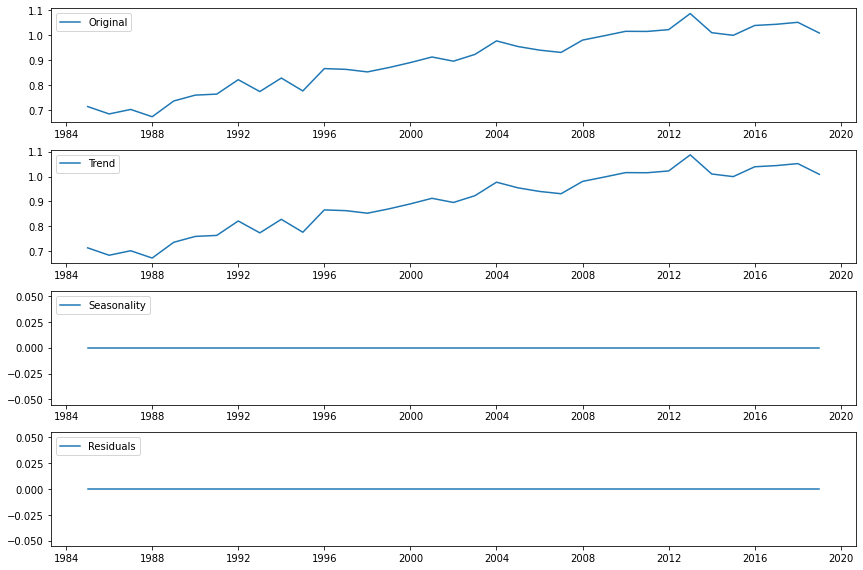

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28004D+00    |proj g|=  2.37059D+00

At iterate    5    f= -1.28280D+00    |proj g|=  1.85538D-01

At iterate   10    f= -1.28466D+00    |proj g|=  7.38210D-01

At iterate   15    f= -1.28490D+00    |proj g|=  5.73463D-02

At iterate   20    f= -1.28519D+00    |proj g|=  3.87382D-02

At iterate   25    f= -1.28531D+00    |proj g|=  8.43479D-02

At iterate   30    f= -1.28533D+00    |proj g|=  5.19096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

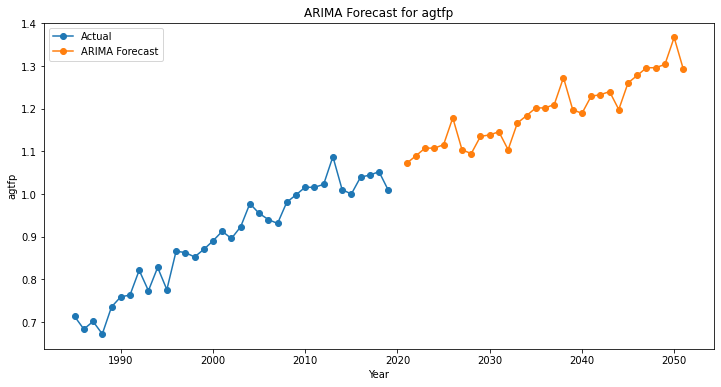

In [18]:
# Convert to numeric to make compatible with ARIMA model
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Drop rows with NaN values in 'year'
df = df.dropna(subset=['year'])

# Convert 'year' to datetime
df['year'] = pd.to_datetime(df['year'], format='%Y')

# Create a time series DataFrame
ts_df = df[['year', 'agtfp']].set_index('year')

# Decompose the time series to analyze trends and seasonality
decomposition = sm.tsa.seasonal_decompose(ts_df['agtfp'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts_df['agtfp'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Fit an ARIMA model
order = (2, 1, 2)
seasonal_order = (1, 1, 1, 12)

model_arima = sm.tsa.SARIMAX(ts_df['agtfp'], order=order, seasonal_order=seasonal_order)
results_arima = model_arima.fit()

# Forecast future years until 2050
forecast_steps = 2050 - df['year'].max().year
forecast_index = pd.date_range(start=str(df['year'].max().year + 1), periods=forecast_steps, freq='A')
forecast_arima = results_arima.get_forecast(steps=forecast_steps).predicted_mean
forecast_df = pd.DataFrame(forecast_arima.values, index=forecast_index, columns=['agtfp'])

# Plot the actual data and ARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(ts_df.index, ts_df['agtfp'], label='Actual', marker='o')
plt.plot(forecast_df.index, forecast_df['agtfp'], label='ARIMA Forecast', marker='o')
plt.title('ARIMA Forecast for agtfp')
plt.xlabel('Year')
plt.ylabel('agtfp')
plt.legend()
plt.show()

5. Plot Results

Finally, we can compare the results of the regression to the results of the forecast model. Both are plotted on the same axis to examine the discrepancy between the two models. 

What we find is that the *expected* Agricultural TFP will be around 1.3, whereas the predicted actual AgTFP (based on fire acreage, fire distance, and air quality index) will only be around 1.1. This implies that the AgTFP will fail to meet the expected productivty standards in the year 2050. 

Results and figure is more thoroughly detailed and analyzed in ```/docs/final_report.pdf```.

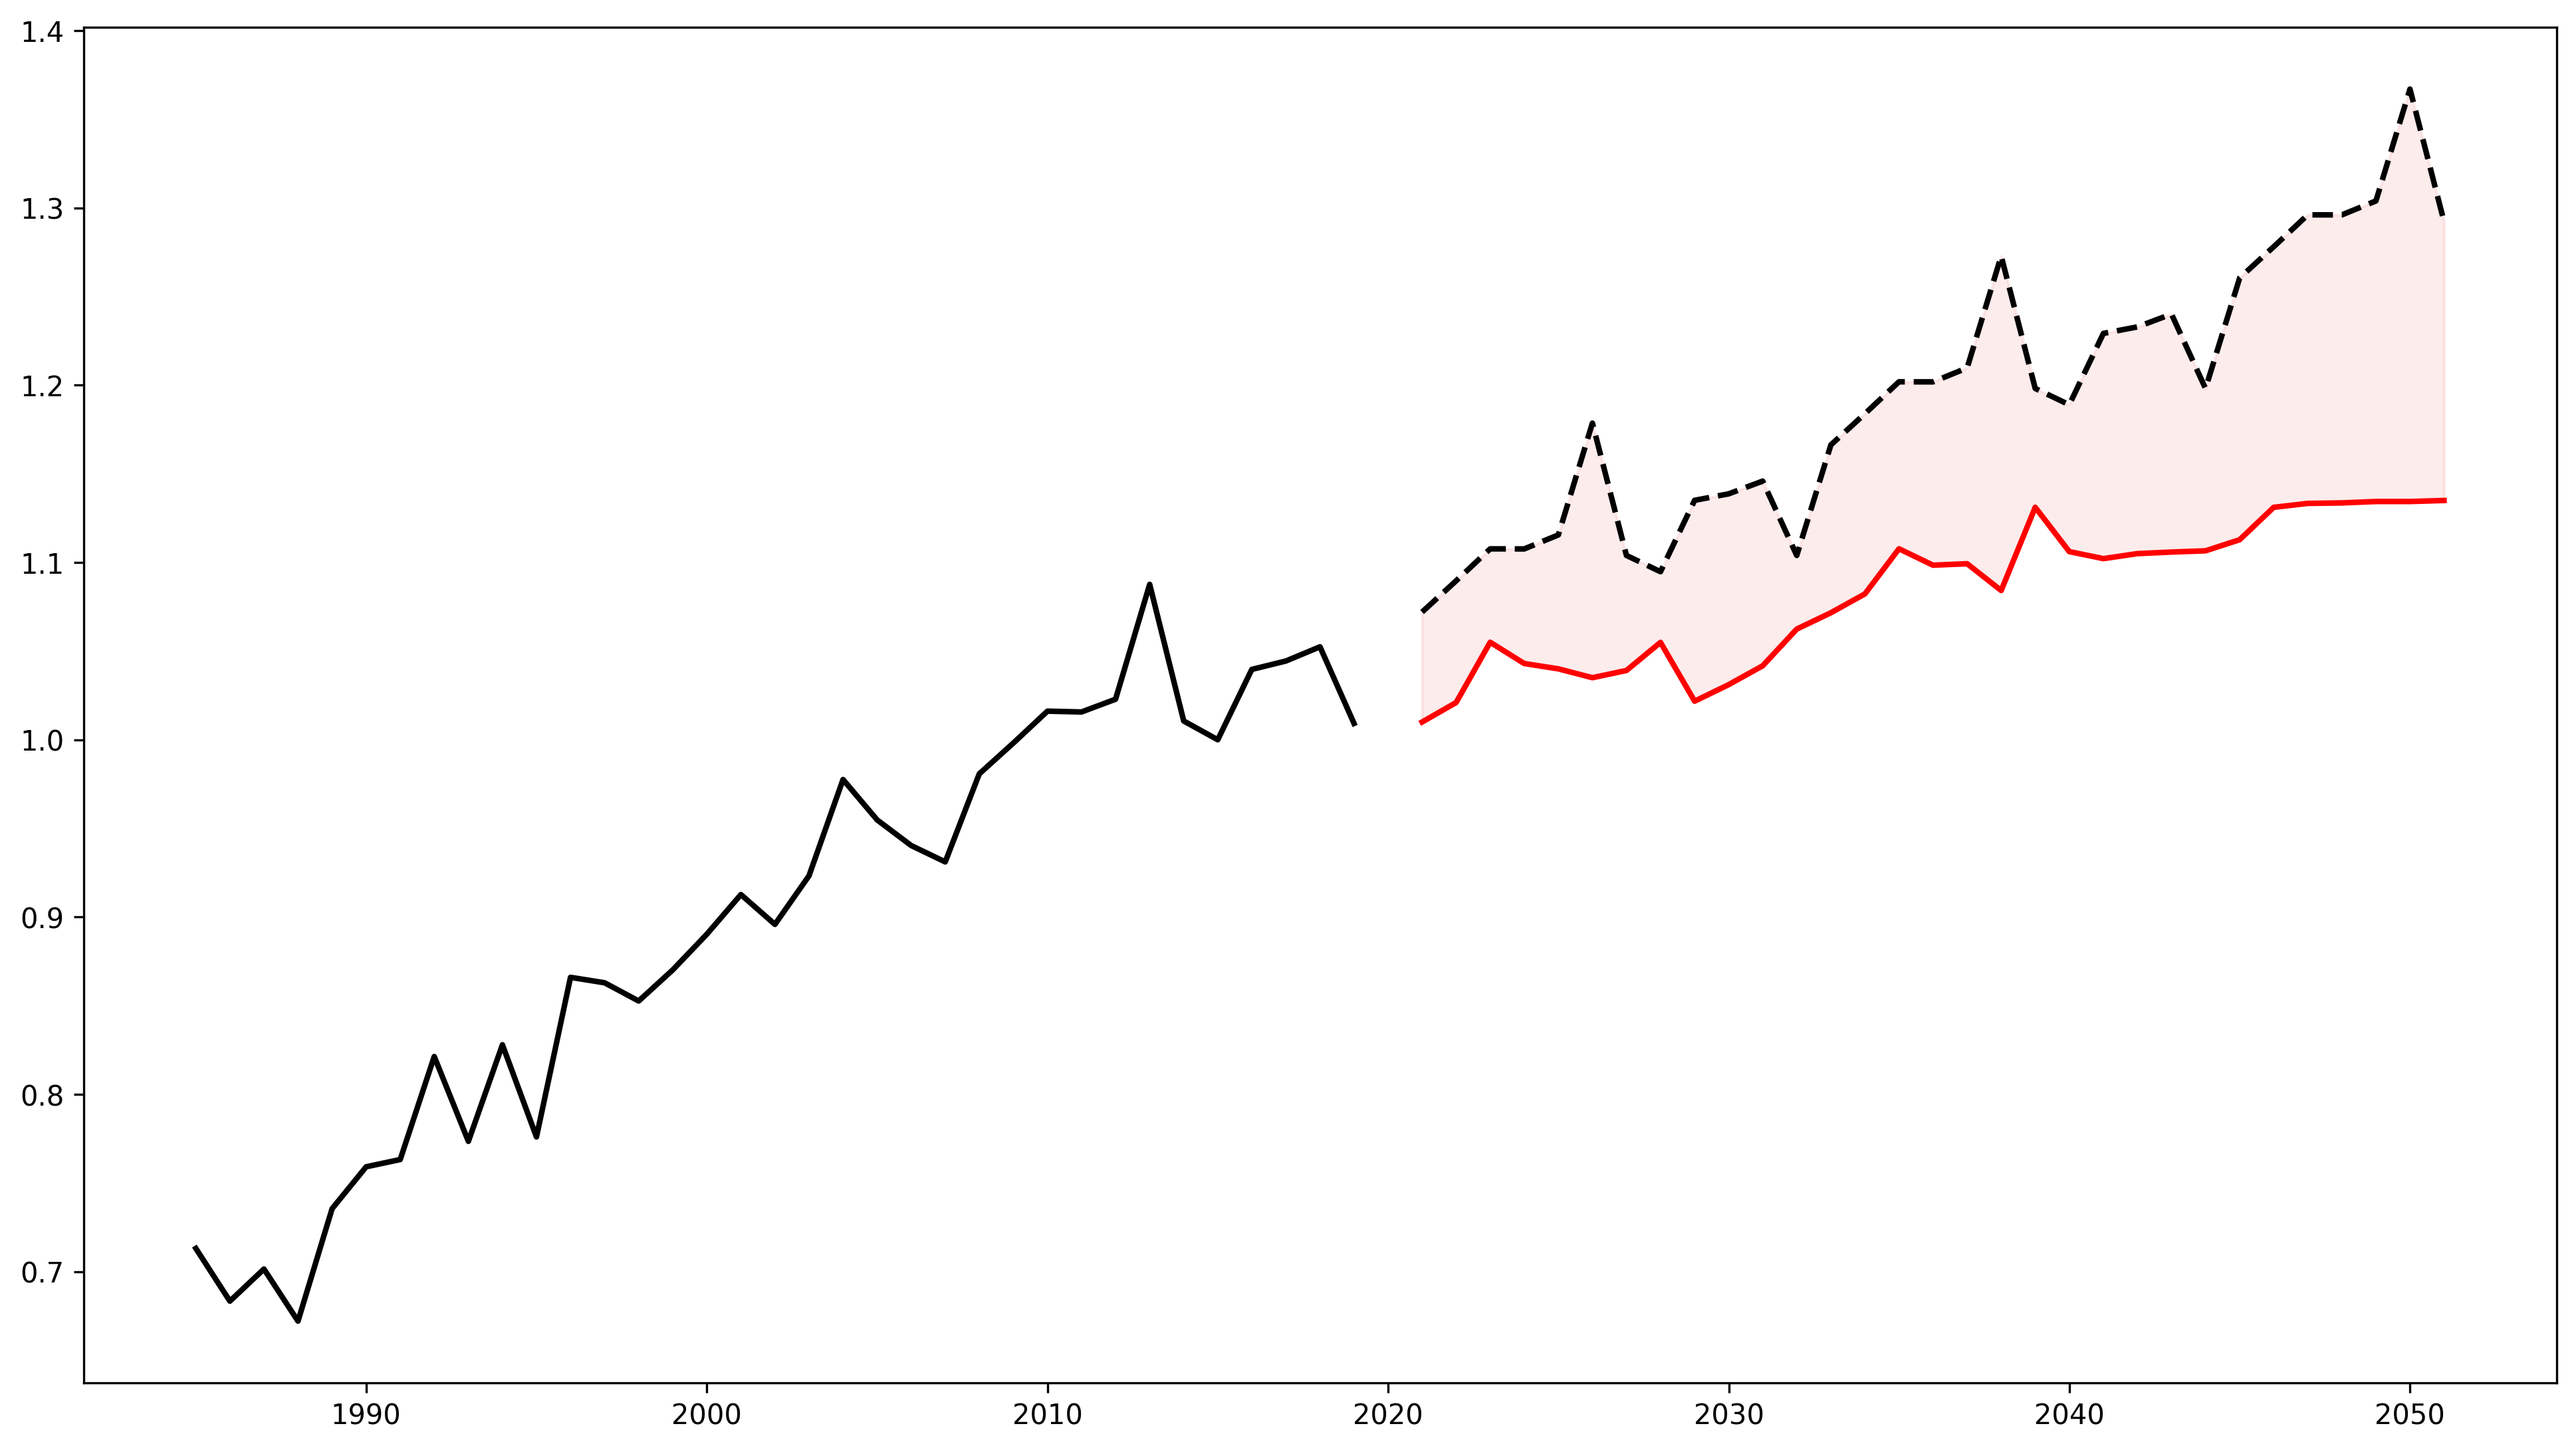

In [26]:
plt.figure(figsize=(16, 9), dpi=300)  # Increase the figure size and resolution

# Plot the actual data
plt.plot(ts_df.index, ts_df['agtfp'], label='Actual', color='black', linestyle='-', linewidth=2)

# Plot the ARIMA forecast in dashed
plt.plot(forecast_df.index, forecast_df['agtfp'], label='ARIMA Forecast', color='black', linestyle='--', linewidth=2)

# Plot the predicted AgTFP in red
plt.plot(forecast_df.index, pred_2050, label='ARIMA Forecast', color='red', linestyle='-', linewidth=2)

# Shade between the discrepancy
plt.fill_between(forecast_df.index, forecast_df['agtfp'], pred_2050, color='lightcoral', alpha=0.15)

# Configure and save output
plt.grid(False)
plt.gca().set_facecolor('none')
plt.savefig('fig1.png')
plt.show()

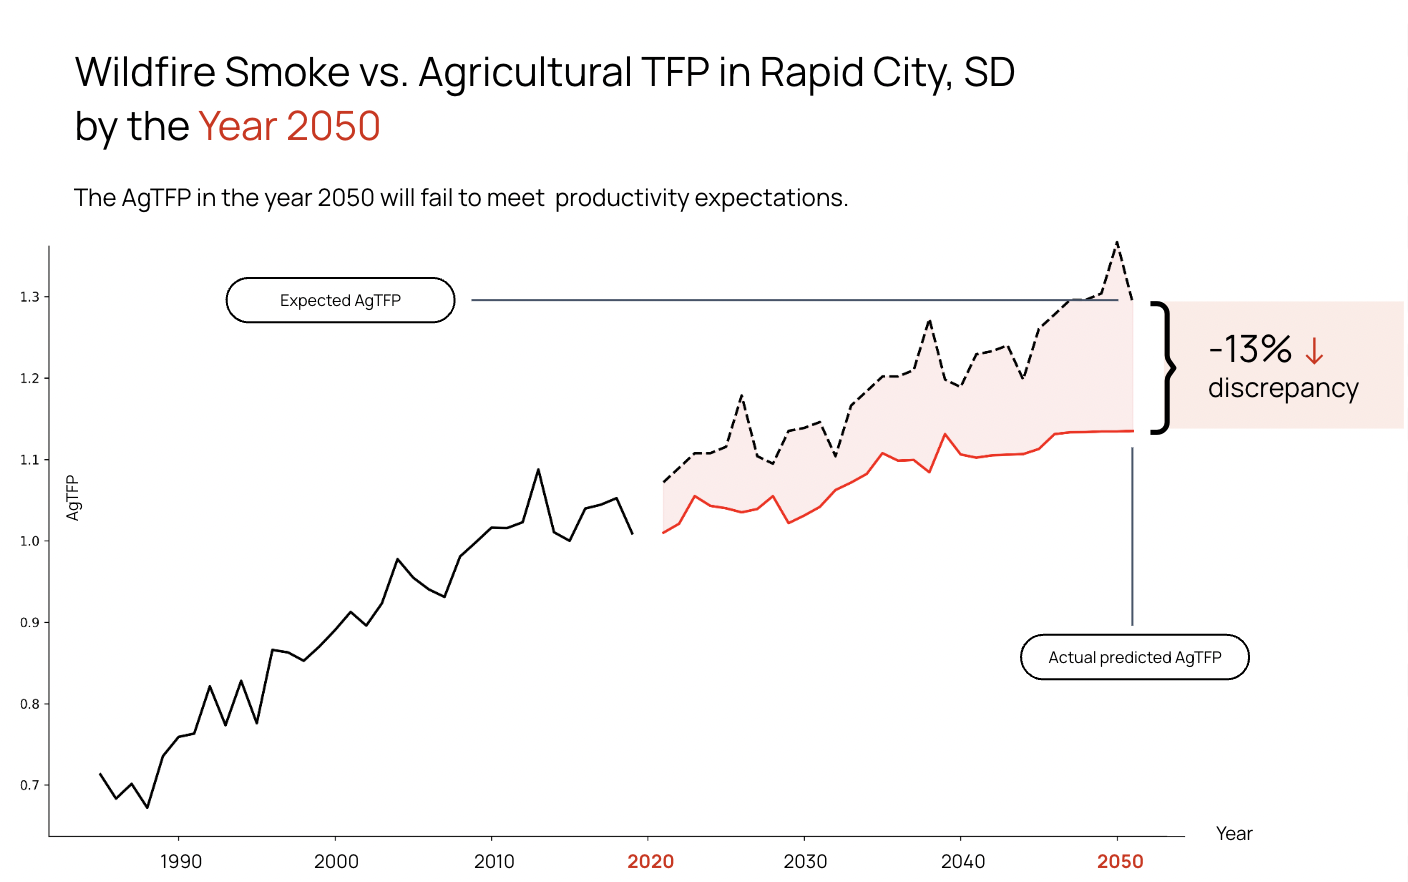

In [16]:
# display complete image with labels and axes

from IPython.display import Image, display


image_path = 'fig1.png'
display(Image(filename=image_path))